In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import yaml

# Read config

In [2]:
with open('../params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

# DuckDB Registration

In [3]:
import duckdb  
conn = duckdb.connect(':memory:')

In [4]:
joined_parquet_dataset = '../' + config["data_load"]["joined_parquet"]
conn.sql('CREATE TABLE evi_data AS SELECT * FROM read_parquet(\'' + joined_parquet_dataset + '\')')

In [5]:
conn.execute('''  
SELECT 
    DISCOVER_DAY,
    DISCOVER_HOUR,
    IP_ADDRESS,
    LONGITUDE,
    LATITUDE,
    NAME,
    PAIR_NAME
FROM
   evi_data
LIMIT 5
''').df()

,REG_NO,ANTENNA,DISCOVER_TIME,formatted_timestamp,Timestamp,DISCOVER_YEAR,DISCOVER_MONTH,DISCOVER_DAY,DISCOVER_HOUR,DISCOVER_MINUTE,DISCOVER_SECOND,IP_ADDRESS,ID,LONGITUDE,LATITUDE,NAME,reader1,reader2,PAIR_NAME
0,8841CE709363F49C4DE4DAAC282B22FE,0,2022-12-21 23:59:59.963,2022-12-21 23:59:59,2022-12-21 23:59:00,2022,12,21,23,59,59,192.168.250.10,501,90.413266,23.794509,To Kakoli New,501,401,Gulshan 2
1,A633B351E3D225CC555D4B25359E9835,1,2022-12-21 23:59:59.606,2022-12-21 23:59:59,2022-12-21 23:59:00,2022,12,21,23,59,59,192.168.250.26,482,90.421319,23.809342,To Notun Baazar New,482,483,Kuril Bishawroad
2,9632CB632F41138B9F05629249BA1DBC,0,2022-12-21 23:59:59.598,2022-12-21 23:59:59,2022-12-21 23:59:00,2022,12,21,23,59,59,192.168.250.2,462,90.410508,23.727862,To Zero Point Circle New,462,494,Zero Point
3,2B30E2AA753F687A4DBB95CDF8E03915,3,2022-12-21 23:59:58.579,2022-12-21 23:59:58,2022-12-21 23:59:00,2022,12,21,23,59,58,192.168.250.50,301,90.383322,23.739047,To Dhanmondi New,301,502,Science Lab
4,580F870FA7F9C3288D7C69C70FCEA34C,3,2022-12-21 23:59:57.683,2022-12-21 23:59:57,2022-12-21 23:59:00,2022,12,21,23,59,57,192.168.250.26,482,90.421319,23.809342,To Notun Baazar New,482,483,Kuril Bishawroad


In [6]:
conn.execute('''  
SELECT 
    Min(DISCOVER_YEAR),
    Max(DISCOVER_YEAR),
    Min(DISCOVER_MONTH),
    Max(DISCOVER_MONTH),
    Min(DISCOVER_DAY),    
    Max(DISCOVER_DAY),
FROM
   evi_data
LIMIT 5
''').df()

,"min(""DISCOVER_YEAR"")","max(""DISCOVER_YEAR"")","min(""DISCOVER_MONTH"")","max(""DISCOVER_MONTH"")","min(""DISCOVER_DAY"")","max(""DISCOVER_DAY"")"
0,2022,2022,12,12,15,21


In [7]:
clean_data_df = conn.execute('''  
SELECT 
    DISCOVER_DAY,
    DISCOVER_HOUR,
    IP_ADDRESS,
    LONGITUDE,
    LATITUDE,
    NAME,
    PAIR_NAME,
    COUNT(REG_NO) AS VEHICLES
FROM
   evi_data
GROUP BY DISCOVER_DAY, DISCOVER_HOUR, IP_ADDRESS, LONGITUDE, LATITUDE, NAME, PAIR_NAME

''').df()

In [8]:
clean_data_df.head()

,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES
0,20,21,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,1177
1,20,21,192.168.250.10,90.413266,23.794509,To Kakoli New,Gulshan 2,498
2,20,21,192.168.250.11,90.413266,23.794509,To Notun Baazar New,Gulshan 2,319
3,20,21,192.168.250.42,90.395889,23.739011,To Motsho Bhaban New,Shahbag Circle,290
4,20,21,192.168.250.27,90.421319,23.809342,To Bishaw Road New,Kuril Bishawroad,925


# Data Split

In [9]:
data = clean_data_df.sample(frac=0.9, random_state=786)
data_unseen = clean_data_df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2218, 8)
Unseen Data For Predictions: (246, 8)


# PyCaret Experiment

In [3]:
from pycaret.regression import *
from pycaret.utils import check_metric
import xgboost

## PyCaret Setup

In [ ]:
s = setup(data = data, target = 'VEHICLES', session_id=123)

Data Type
DISCOVER_DAY	Categorical
DISCOVER_HOUR	Numeric
IP_ADDRESS	Categorical
LONGITUDE	Numeric
LATITUDE	Numeric
NAME	Categorical
PAIR_NAME	Categorical
VEHICLES	Label

In [ ]:
s[0]

## PyCaret Models

In [11]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,44.9415,5755.2116,75.0173,0.9575,0.4052,0.3767,0.0980
et,Extra Trees Regressor,45.8050,6498.3427,79.1365,0.9512,0.3313,0.2811,0.1100
rf,Random Forest Regressor,47.2446,6561.3630,78.9964,0.9510,0.3485,0.3169,0.1110
lightgbm,Light Gradient Boosting Machine,52.5735,7049.0911,83.2132,0.9474,0.5184,0.6529,0.0190
gbr,Gradient Boosting Regressor,63.0055,9771.7512,97.5854,0.9266,0.5834,0.7732,0.0400
dt,Decision Tree Regressor,58.9239,10834.9022,102.2317,0.9198,0.4126,0.3856,0.0070
knn,K Neighbors Regressor,68.0357,14767.3798,118.9874,0.8919,0.5370,0.6878,0.0090
ada,AdaBoost Regressor,122.3931,21938.9361,147.7060,0.8359,1.2340,5.1492,0.0410
lr,Linear Regression,153.3811,43996.9040,208.8119,0.6706,1.0935,2.8256,0.6500
ridge,Ridge Regression,153.4318,44027.5225,208.9150,0.6704,1.1002,2.7819,0.0060


In [12]:
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,50.9910,6971.6096,83.4962,0.9513,0.3842,0.2853
1,48.1525,6456.7761,80.3541,0.9439,0.4061,0.3754
2,44.6319,5065.4517,71.1720,0.9621,0.3778,0.3709
3,46.1402,7337.3388,85.6583,0.9497,0.3391,0.3497
4,54.2115,9517.6508,97.5584,0.9416,0.3266,0.3249
5,39.9080,4473.9755,66.8878,0.9672,0.5463,0.3471
6,44.7577,5483.6083,74.0514,0.9556,0.4368,0.4762
7,44.1566,4677.8647,68.3949,0.9649,0.4331,0.5390
8,39.4680,4412.0527,66.4233,0.9628,0.4623,0.3467


## Plot Feature Importance

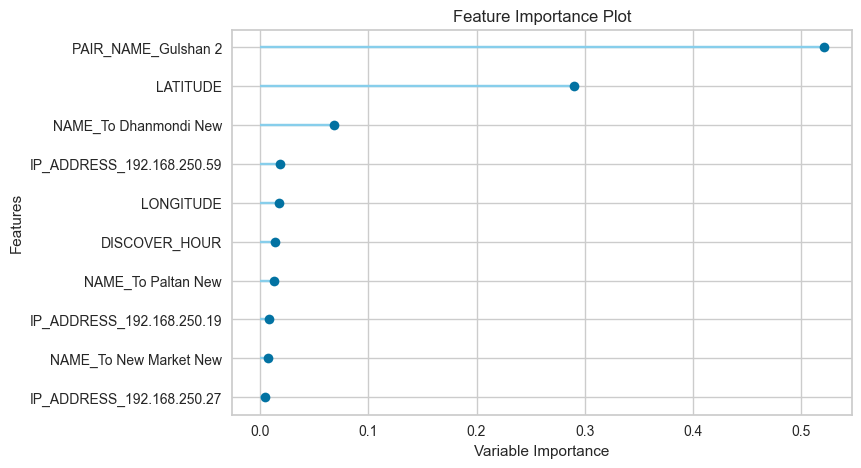

In [13]:
plot_model(xgboost, plot='feature')

## Tune and Finalize Model

In [14]:
tuned_xgboost = tune_model(xgboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,51.7303,7149.7493,84.5562,0.9501,0.3775,0.3039
1,53.6093,7980.1247,89.3315,0.9306,0.4328,0.4269
2,43.6012,4315.6708,65.6938,0.9677,0.4365,0.5642
3,42.6051,5806.8205,76.2025,0.9602,0.4450,0.4507
4,58.4182,10037.1346,100.1855,0.9385,0.4268,0.4688
5,43.3127,4631.5740,68.0557,0.9660,0.4613,0.4381
6,47.9172,6222.7420,78.8844,0.9496,0.4257,0.4713
7,43.1935,4058.9988,63.7103,0.9695,0.3918,0.3905
8,38.4332,4364.7414,66.0662,0.9632,0.5031,0.4726


In [15]:
print(tuned_xgboost)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=290, n_jobs=-1, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)


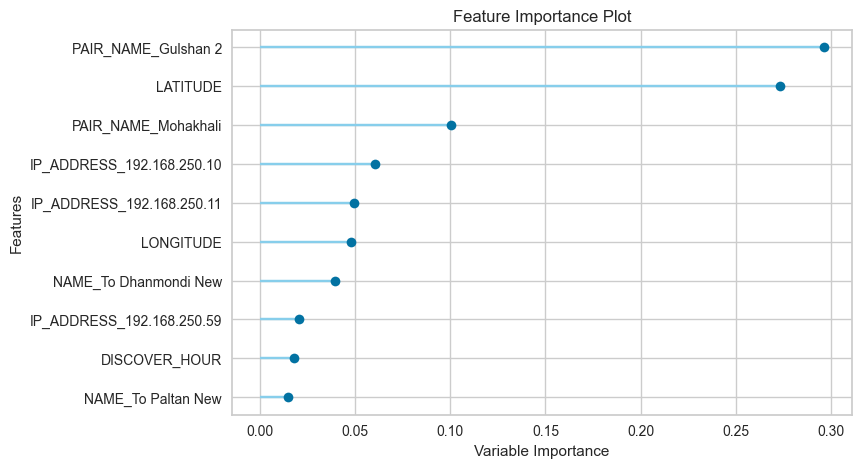

In [16]:
plot_model(tuned_xgboost, plot='feature')

In [17]:
evaluate_model(tuned_xgboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict

In [18]:
predict_model(tuned_xgboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,49.3091,6949.8456,83.3657,0.9514,0.3638,0.3278


In [19]:
final_xgboost = finalize_model(tuned_xgboost)
print(final_xgboost)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=290, n_jobs=-1, num_parallel_tree=None,
             objective='reg:squarederror', predictor=None, ...)


In [20]:
predict_model(final_xgboost);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,15.7774,532.0785,23.0668,0.9963,0.2546,0.1394


In [21]:
data_unseen

,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES
0,20,21,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1115
1,20,21,192.168.250.67,90.401916,23.709414,To Tatibazar New,Buriganga Bridge,23
2,20,21,192.168.250.3,90.410508,23.727862,To Paltan New,Zero Point,185
3,18,20,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,1179
4,18,20,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1614
...,...,...,...,...,...,...,...,...
241,15,11,192.168.250.43,90.395889,23.739011,To Shahbag Circle New,Shahbag Circle,255
242,15,5,192.168.250.35,90.407661,23.737570,To Kakrail Mosque New,Kakrail,13
243,15,11,192.168.250.59,90.347026,23.782804,To Aminbazar New,Gabtoli Mazar Road,523
244,15,6,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,230


In [22]:
unseen_predictions = predict_model(final_xgboost, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,46.8830,6220.8836,78.8726,0.9575,0.4024,0.3709


,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES,Label
0,20,21,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1115,1010.331604
1,20,21,192.168.250.67,90.401916,23.709414,To Tatibazar New,Buriganga Bridge,23,-0.513735
2,20,21,192.168.250.3,90.410508,23.727862,To Paltan New,Zero Point,185,193.923996
3,18,20,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,1179,1264.161255
4,18,20,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1614,1184.385986


In [23]:
check_metric(unseen_predictions.VEHICLES, unseen_predictions.Label, 'R2')

0.9575

## Save Model

In [29]:
save_model(final_xgboost,'../models/Final_XGBoost_Model_01Mar2023')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='VEHICLES',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strateg...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                

## Loading the Saved Model

In [6]:
saved_final_lightgbm = load_model('../models/Final_XGBoost_Model_01Mar2023')

Transformation Pipeline and Model Successfully Loaded


In [31]:
new_prediction = predict_model(saved_final_lightgbm, data=data_unseen)
new_prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,46.8830,6220.8836,78.8726,0.9575,0.4024,0.3709


,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES,Label
0,20,21,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1115,1010.331604
1,20,21,192.168.250.67,90.401916,23.709414,To Tatibazar New,Buriganga Bridge,23,-0.513735
2,20,21,192.168.250.3,90.410508,23.727862,To Paltan New,Zero Point,185,193.923996
3,18,20,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,1179,1264.161255
4,18,20,192.168.250.19,90.400117,23.788739,To Mohakhali Circle New,Mohakhali,1614,1184.385986


In [32]:
from pycaret.utils import check_metric
check_metric(new_prediction.VEHICLES, new_prediction.Label, 'R2')

0.9575

DISCOVER_DAY	DISCOVER_HOUR	IP_ADDRESS	LONGITUDE	LATITUDE	NAME	PAIR_NAME	VEHICLES

0	20	21	192.168.250.26	90.421319	23.809342	To Notun Baazar New	Kuril Bishawroad	1177

In [123]:
# Convert dictionary to DataFrame with a single row
df = data_unseen.iloc[[201]].reset_index(drop=True)

In [124]:
df

,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES
0,15,19,192.168.250.18,90.400117,23.788739,To Kakoli New,Mohakhali,1642


In [125]:
new_prediction = predict_model(saved_final_lightgbm, data=df)
new_prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1.9648,3.8606,1.9648,nan,0.0012,0.0012


,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES,Label
0,15,19,192.168.250.18,90.400117,23.788739,To Kakoli New,Mohakhali,1642,1643.964844


In [132]:
new_data = {'DISCOVER_DAY':20, 'DISCOVER_HOUR': 21, \
            'IP_ADDRESS': '192.168.250.26',\
            'LONGITUDE':90.421319, 'LATITUDE':23.809342, \
            'NAME': 'To Notun Baazar New', 'PAIR_NAME': 'Kuril Bishawroad', \
            'VEHICLES':1117.}

In [133]:
# Convert dictionary to DataFrame with a single row
df = pd.DataFrame(new_data, index=[0])

In [134]:
new_prediction = predict_model(saved_final_lightgbm, data=df)
new_prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,44.5493,1984.6416,44.5493,nan,0.0391,0.0399


,DISCOVER_DAY,DISCOVER_HOUR,IP_ADDRESS,LONGITUDE,LATITUDE,NAME,PAIR_NAME,VEHICLES,Label
0,20,21,192.168.250.26,90.421319,23.809342,To Notun Baazar New,Kuril Bishawroad,1117.0,1161.549316
